In [2]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2

# import standard libs
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json
os.environ['THEANO_FLAGS'] = 'device=cpu'
# import python scientific stack
import pandas as pd
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
import multiprocessing as mp
from multiprocessing import cpu_count 
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import pymc3 as pm
import numba as nb
import math

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

import plotnine as pn

plt.style.use('seaborn-talk')
plt.style.use('bmh')
#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 14,10
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm, tqdm_notebook

import missingno as msno

import os
import sys
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0] # orrible, but runs
#nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from src.utils.utils import *
import src.data.utils as du
import src.features.bars as brs
import src.features.snippets as snp

import copyreg, types
copyreg.pickle(types.MethodType,snp._pickle_method,snp._unpickle_method)
RANDOM_STATE = 777

pdir = get_relative_project_dir('Adv_Fin_ML_Exercises')
data_dir = pdir/'data'/'processed'

print()
%watermark -p pandas,numpy,numba,pymc3,sklearn,statsmodels,scipy,matplotlib,seaborn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2018-10-28T14:12:48+01:00

CPython 3.6.6
IPython 7.0.1

compiler   : GCC 8.0.1 20180414 (experimental) [trunk revision 259383
system     : Linux
release    : 4.15.0-36-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

pandas 0.23.4
numpy 1.15.3
numba 0.40.1
pymc3 3.5
sklearn 0.20.0
statsmodels 0.9.0
scipy 1.1.0
matplotlib 3.0.1
seaborn 0.9.0


# Pipeline
The goal is to produce a clean, easy to use, notebook which collects the main steps of the book
1. Import raw data
2. Sample data es. dollar value
3. Reduce overlappling (weighted sample)
4. Fractional differentiation
5. Feature importance analysis
6. Cross Validation (purged K-fold)

## 1. Import raw data

In [28]:
infp=Path(data_dir/'clean_IVE_fut_prices.parquet')
df = pd.read_parquet(infp)
#cprint(df)


## 2. Sample data es. dollar value

In [29]:
mad = du.mad_outlier(df.price.values.reshape(-1,1))
df = df.loc[~mad]

dv_rs = brs.dollar_bar_df(df=df, dv_column='dv', m=1_000_000)
print('Before remove duplicated index', dv_rs.shape)
dv_rs = dv_rs.loc[~dv_rs.index.duplicated(keep='last')]
print('After removed duplicated index', dv_rs.shape)
dbars = dv_rs.copy()

100%|██████████| 1430998/1430998 [00:00<00:00, 2650951.56it/s]

Before remove duplicated index (51439, 6)
After removed duplicated index (50662, 6)


In [30]:
close = dbars.price.copy()
dailyVol = snp.getDailyVol(close, span0=100)
dailyVol.dropna(inplace=True)
cprint(dailyVol)
dailyVol.mean()

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     dailyVol
dates                        
2018-10-19 15:57:50  0.006133
2018-10-19 15:59:07  0.006080
2018-10-19 15:59:37  0.006025
2018-10-19 15:59:58  0.005971
2018-10-19 16:00:00  0.005912
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50634 entries, 2009-09-29 10:04:46 to 2018-10-19 16:00:00
Data columns (total 1 columns):
dailyVol    50634 non-null float64
dtypes: float64(1)
memory usage: 791.2 KB
None
-------------------------------------------------------------------------------



0.007344448755722572

In [31]:
tEvents = snp.getTEvents(close, h=dailyVol.mean())
print('######### tEvents ############')
cprint(tEvents)

100%|██████████| 50660/50660 [00:04<00:00, 11161.01it/s]

######### tEvents ############
-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                                      0
2018-10-19 11:01:25 2018-10-19 11:01:25
2018-10-19 12:19:35 2018-10-19 12:19:35
2018-10-19 13:09:23 2018-10-19 13:09:23
2018-10-19 14:05:59 2018-10-19 14:05:59
2018-10-19 15:04:39 2018-10-19 15:04:39
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6326 entries, 2009-09-28 11:37:06 to 2018-10-19 15:04:39
Data columns (total 1 columns):
0    6326 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 98.8 KB
None
-------------------------------------------------------------------------------



In [32]:
t1 = snp.addVerticalBarrier(tEvents, close[dailyVol.index])
cprint(t1)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                                  dates
2018-10-18 11:34:44 2018-10-19 11:39:05
2018-10-18 12:27:04 2018-10-19 12:30:04
2018-10-18 13:32:02 2018-10-19 13:40:12
2018-10-18 14:36:20 2018-10-19 14:44:46
2018-10-18 15:28:31 2018-10-19 15:33:15
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6320 entries, 2009-09-28 11:37:06 to 2018-10-18 15:28:31
Data columns (total 1 columns):
dates    6320 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 98.8 KB
None
-------------------------------------------------------------------------------



In [33]:
# select profit taking stoploss factor
ptsl = [1,1]
# target is dailyVol computed earlier
target=dailyVol
# select minRet
minRet = 0.01
# get cpu count - 1
cpus = cpu_count() - 1

events = snp.getEvents(close, tEvents, ptsl, target, minRet,cpus,t1=t1)
print('######### events ############')
cprint(events)

######### events ############
-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                                     t1      trgt
2018-10-15 11:56:12 2018-10-16 12:03:08  0.011597
2018-10-15 13:28:14 2018-10-16 13:32:00  0.011443
2018-10-15 14:59:30 2018-10-16 15:05:08  0.011370
2018-10-15 15:59:57 2018-10-16 11:29:56  0.010745
2018-10-16 09:33:33 2018-10-16 14:09:26  0.010442
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1832 entries, 2009-10-02 09:32:42 to 2018-10-16 09:33:33
Data columns (total 2 columns):
t1      1832 non-null datetime64[ns]
trgt    1832 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 42.9 KB
None
-------------------------------------------------------------------------------



2018-10-28 14:23:16.942010 100.0% applyPtSlOnT1 done after 0.03 minutes. Remaining 0.0 minutes.


## 3. Reduce overlappling (weighted sample)

2018-10-28 14:27:39.011511 100.0% mpNumCoEvents done after 0.01 minutes. Remaining 0.0 minutes.


(50489,)


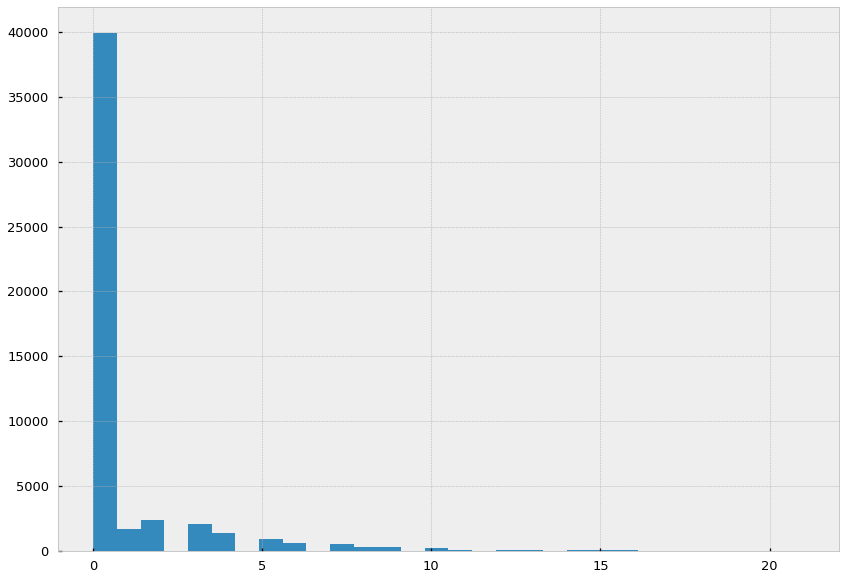

In [41]:
numCoEvents = snp.mpPandasObj(snp.mpNumCoEvents,('molecule',events.index),                         
                              cpus,closeIdx=close.index,t1=events['t1'])
print(numCoEvents.shape)

plt.hist(numCoEvents, bins=30)
plt.show()

In [ ]:
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(close.index).fillna(0)
out=pd.DataFrame()
out['tW'] = snp.mpPandasObj(snp.mpSampleTW,('molecule',events.index),
                            cpus,t1=events['t1'],numCoEvents=numCoEvents)
print(out.shape)
## example ##
out['w']=snp.mpPandasObj(snp.mpSampleW,('molecule',events.index),cpus,
                         t1=events['t1'],numCoEvents=numCoEvents,close=close)
out['w']*=out.shape[0]/out['w'].sum()
print('######### out ############')
cprint(out)

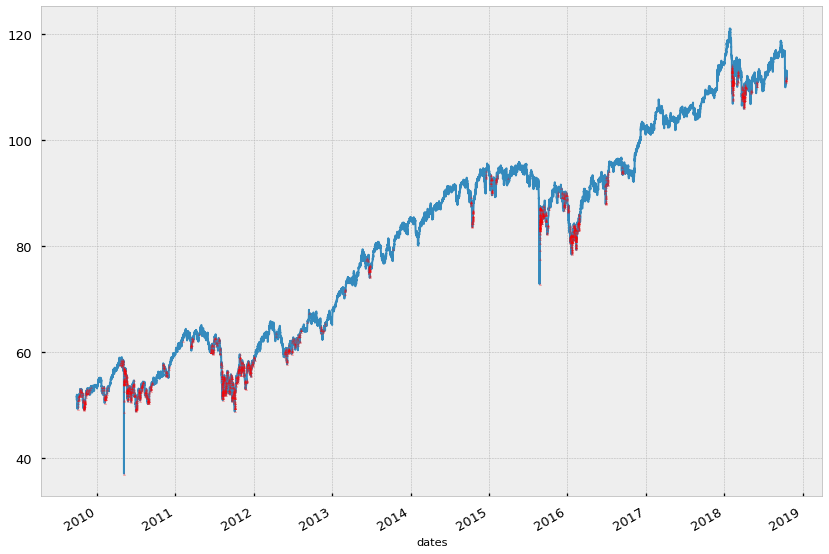

In [35]:
dv_rs.price.plot()
dv_rs.loc[out.index, 'price'].plot(ls='', marker='^', markersize=3, alpha=0.3, color='red')
#df.price.plot()
plt.show()

## 4. Fractional differentiation